# Decision Tree Project Tutorial

In [46]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from numpy.random import seed, choice
from collections import Counter
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import pandas as pd

# Cargar los datos
df = pd.read_csv('/workspaces/Decision_tree_vicentepolo/data/raw/diabetes.csv') 

# Exploratory Data Analysis

Inspeccion Inicial

In [47]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [48]:
print("Las dimensiones del dataframe son ", df.shape) 
print(df.info())  

Las dimensiones del dataframe son  (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


Todas las columnas son numéricas, por lo que no hay que factorizar o transformar columnas object

### Estadística numérica

In [49]:
print(df.describe())  

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

Análisis de valores faltantes

In [50]:
print(df.isnull().sum())  

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


<Axes: >

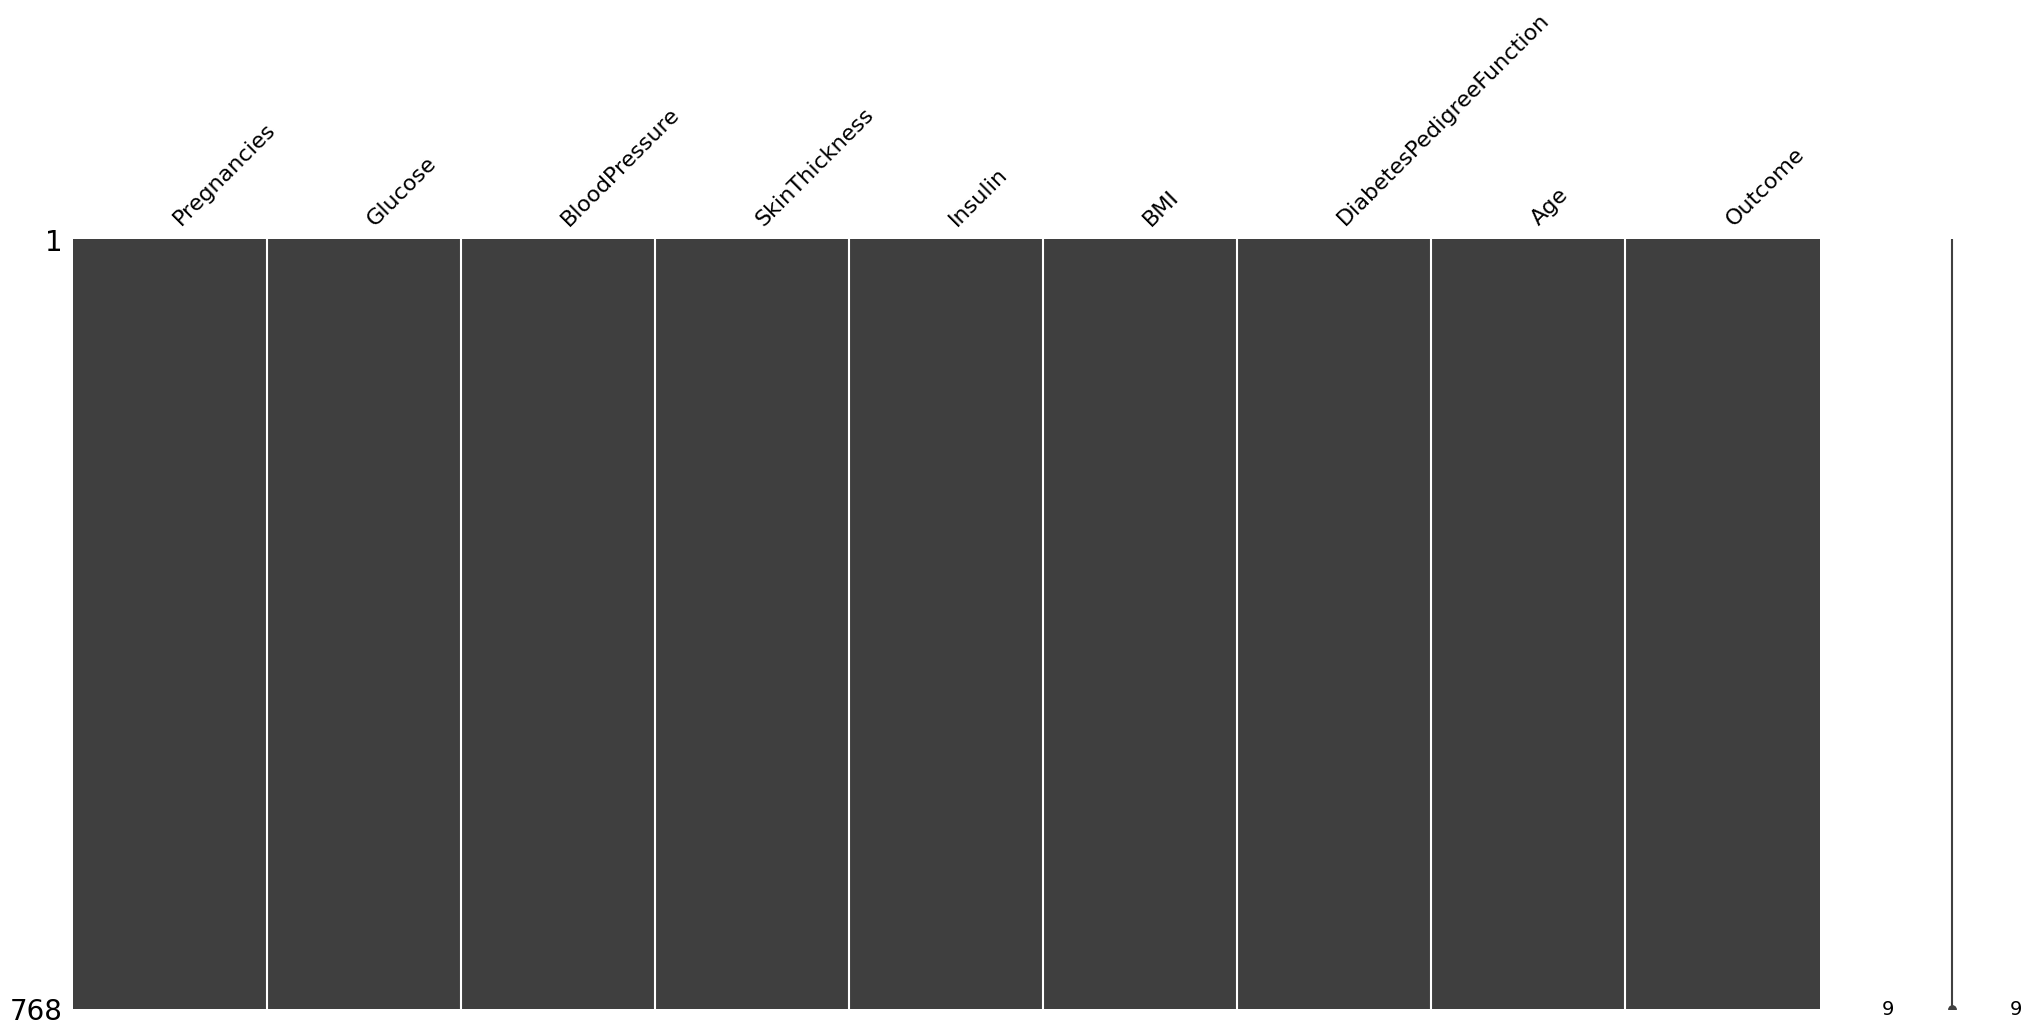

In [51]:
msno.matrix(df)

Valores duplicados

In [52]:
df.duplicated().sum()

np.int64(0)

# Análisis de las variables

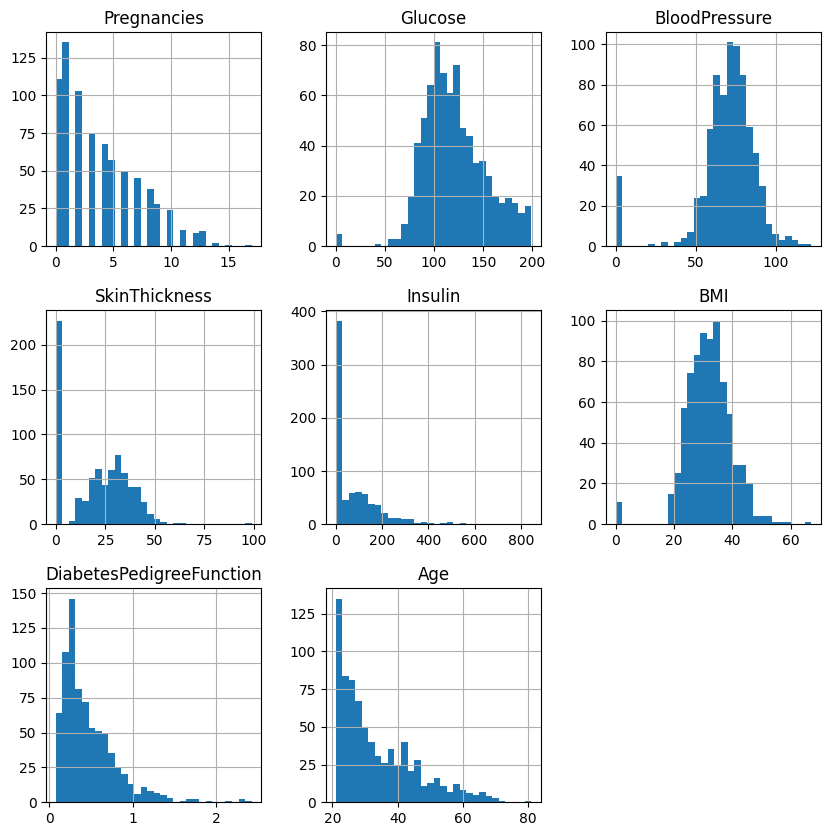

In [53]:

df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
     'BMI', 'DiabetesPedigreeFunction', 'Age']].hist(bins=30, figsize=(10, 10))
plt.show()

Como se puede comprobar en el gráfico tenemos un problema: 

Hay valores 0 que corresponden a datos que no están correctamente inscritos. No se puede tener ni presion arterial 0, ni Indice de Masa Corporal 0 , glucosa, insulina o grosor de la piel....

Para poder transformar con esos datos, voy a imputarlos usar la media. No uso KNN porque no estoy nada satisfecho como ha funcionado, y porque así conozco maneras alternativas. 

In [54]:
df['Glucose'] = df['Glucose'].replace(0, df['Glucose'].mean())
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].mean())
df['BMI'] = df['BMI'].replace(0, df['BMI'].mean())
df['SkinThickness'] = df['SkinThickness'].replace(0, df['SkinThickness'].mean())
df['Insulin'] = df['Insulin'].replace(0, df['Insulin'].mean())

Vuelvo a comprobar los datos

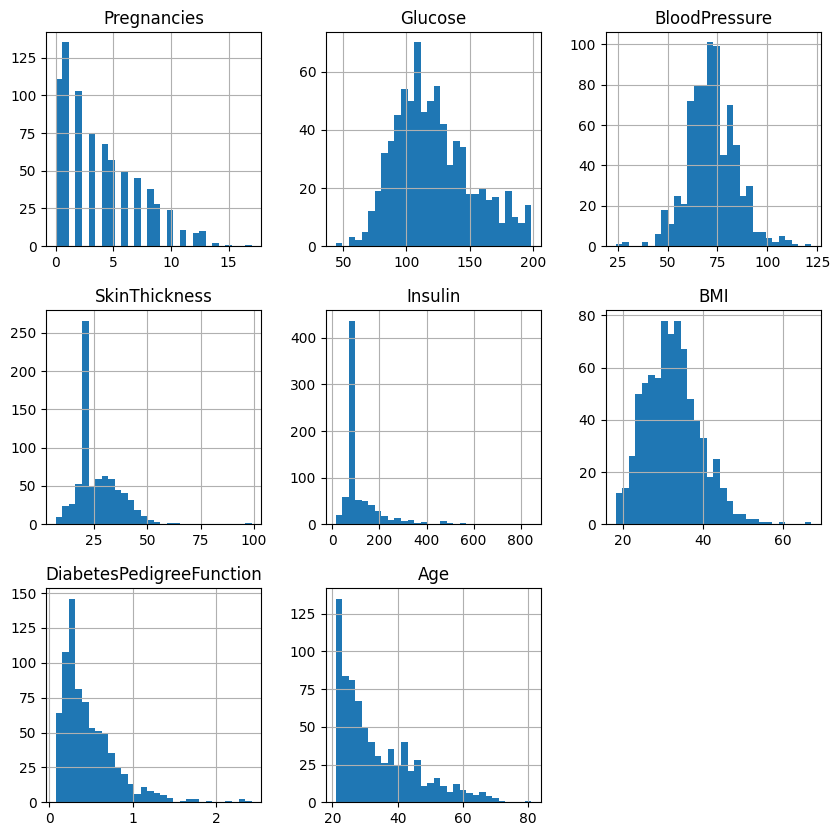

In [55]:
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
     'BMI', 'DiabetesPedigreeFunction', 'Age']].hist(bins=30, figsize=(10, 10))
plt.show()

He optado para poder estar mas seguro, contar los 0 en cada columna. 

In [56]:
num_cero = (df == 0).sum()

print("Valores iguales a 0 en cada columna:")
print(num_cero)

Valores iguales a 0 en cada columna:
Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


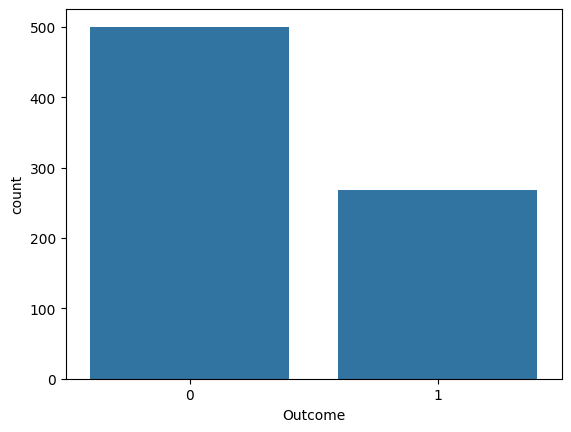

In [57]:
sns.countplot(x='Outcome', data=df)
plt.show()

En la prediccion de diabetes, se ve como de los datos que tenemos hay mas frecuencia en un resultado negativo. (0 corresponde a negativo)

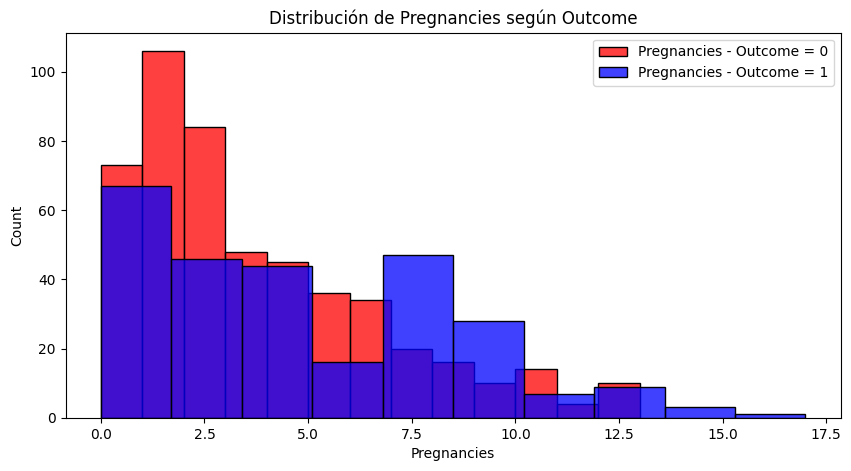

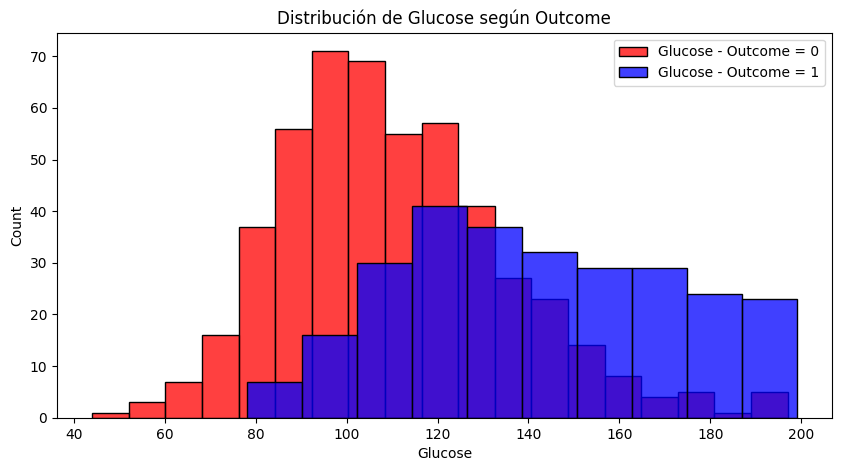

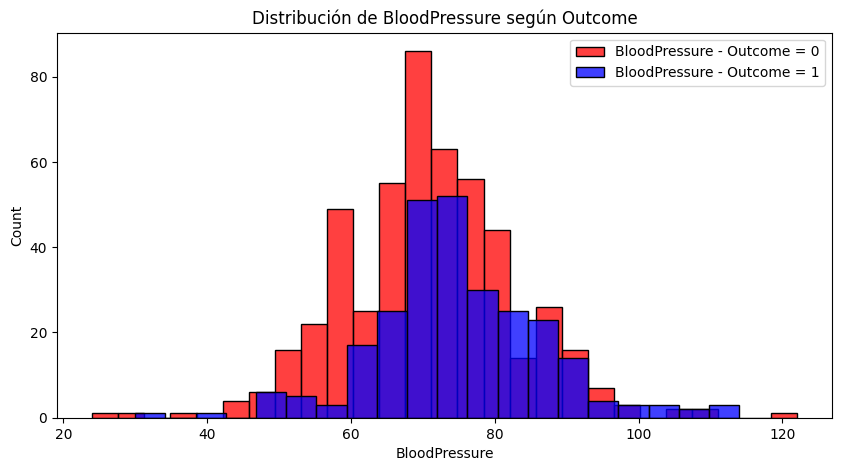

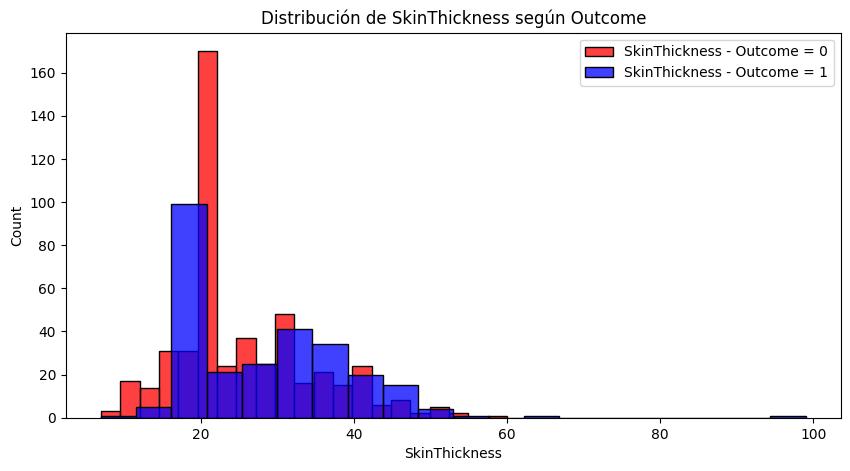

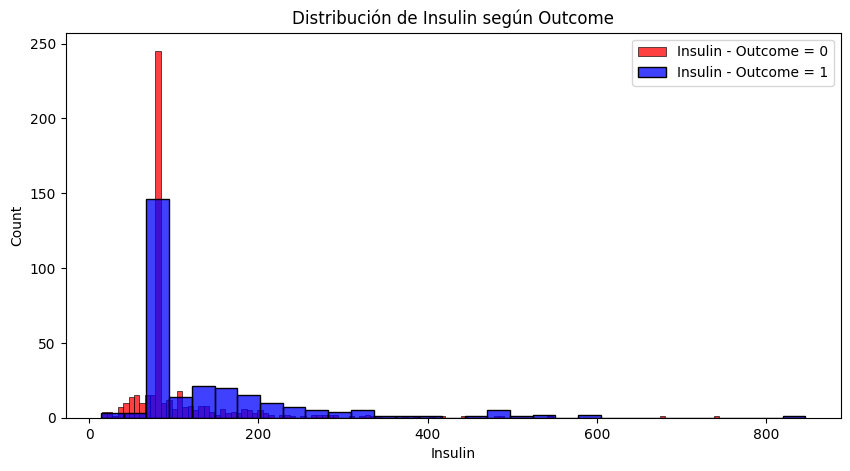

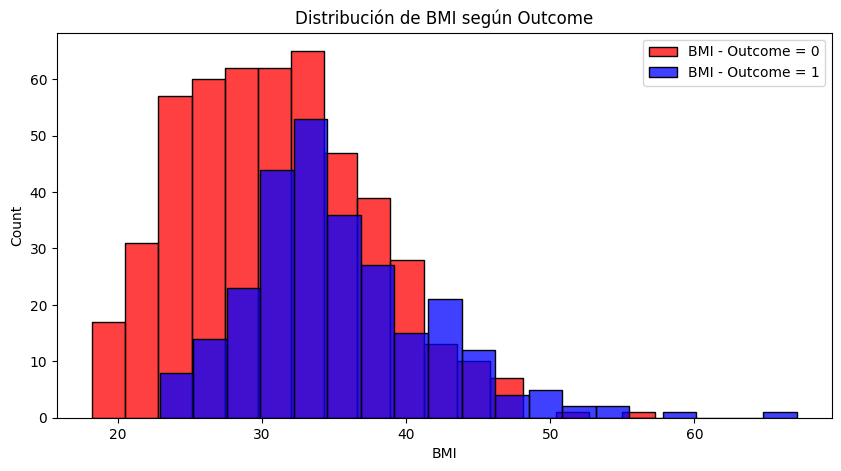

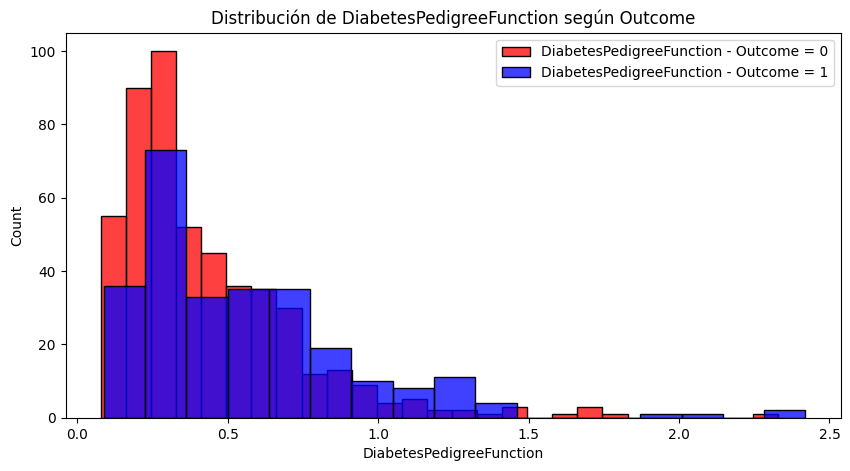

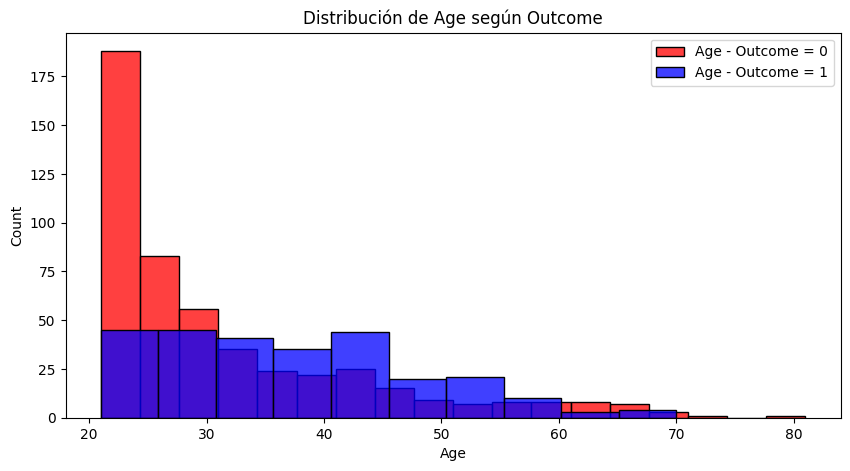

In [58]:
for column in df.columns[:-1]:

    plt.figure(figsize=(10, 5))
    sns.histplot(df[df['Outcome'] == 0][column],  color='red', label=f'{column} - Outcome = 0')
    sns.histplot(df[df['Outcome'] == 1][column],  color='blue', label=f'{column} - Outcome = 1')
    plt.title(f'Distribución de {column} según Outcome')
    plt.legend()
    plt.show()

### Interpretación del análisis univariado: 

Embarazo / Outcome:  Hay una mayor frecuencia positiva en mujeres entre 0 y 2 embarazos. También existen valores que despues tendremos que explicar si son outliers o no, con un valor máximo de 17. 

He estado buscando antes de explorar si son outliers, y en un principio podrían ser posibles si provienen de un estudio médico, pero despues lo exploraremos. 

Glucosa / Outcome: De manera evidente, aquellos con la glucosa mas alta tienen un resultado positivo en Outcome, con valores que comienzan a partir de los 110 y su mayor pico en 120. 

Presión sanguínea / Outcome: Los valores no representan una diferencia significativa, con prsiones sanguíneas alrededor de los 70. Hay valores quizá algo altos, con un máximo de 120 en Outcome negativo. A tener en cuente para el boxplot.

Grosor de la piel / Outcome: He regularizado los valores 0 que aparecían y la frecuencia se situa por encima de 20, no obstante, no hay una clara diferencia entre aquellas personas con diabetes y las que no. Quizá otro outlier que se encuentra cerca de 100.

Insulina /Outcome : Los valores mas altos se encuentran en el mismo rango. No obstante se observa como, a pesar que la frecuencia es baja, los valores positivos se extienden hasta mas haya de 800.

IMC  / Outcome:  Se considera obesidad tipo 1 a partir de 30, pero por encima de 25 se considera sobrepeso. Se puede ver como a pesar de que no es un factor determinante, el numero de personas con resultado positivo s disparan a partir del sobrepeso, y baja la frecuencia justo antes de la obesidad tipo 3, conocida como mórbida. Pero no desaparece.

Diabetespedigreefunction y Outcome: Desconozco el significado de esta variable, pero los valores son parejos, siguiendo el mismo patrón, el rsultado positivo es menos frecuente.

Edad y Outcome: Los resultados en frecuencia se mantienen estables (casi 50) en edades comprendidas entre los 20 y 45 años, su frecuencia baja entre 46-60, llegando a tener una menor frecuencia que la positiva en edades superiores. 

Correlación entre variables

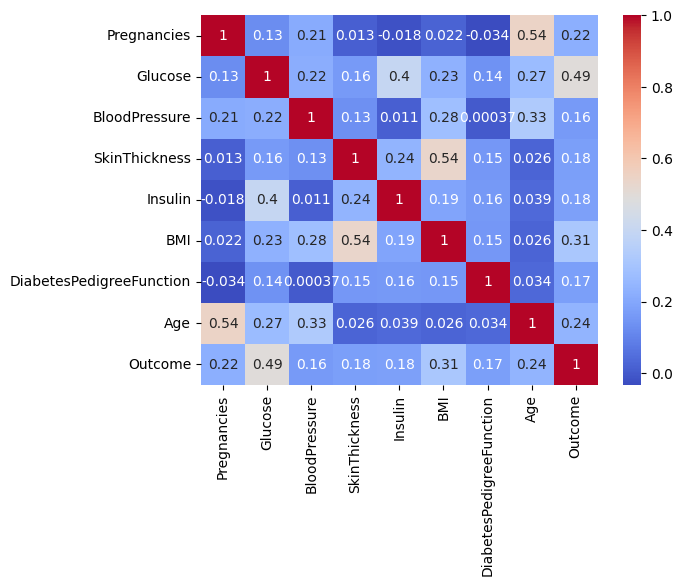

In [59]:
correlation_matrix = df.corr()  # Matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Para lo que nos interesa, podemos comprobar como Glucosa, BMI tienen una relevancia constatada con Outcome. 

En menor medida, podemos vr como el embarazo, la edad, e incluso la insulina, tienen una relevancia no tan significativa.

### Pasamos a hacer los boxplot para analizar posibles outliers

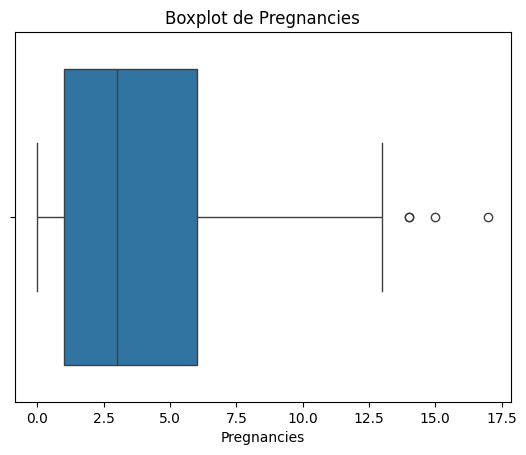

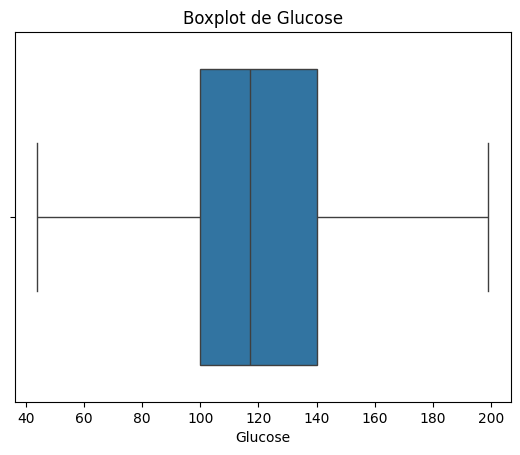

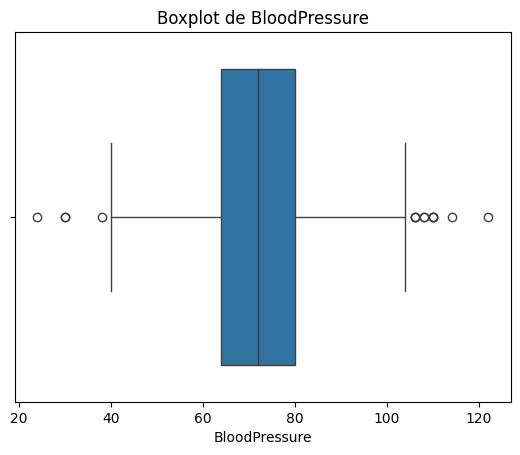

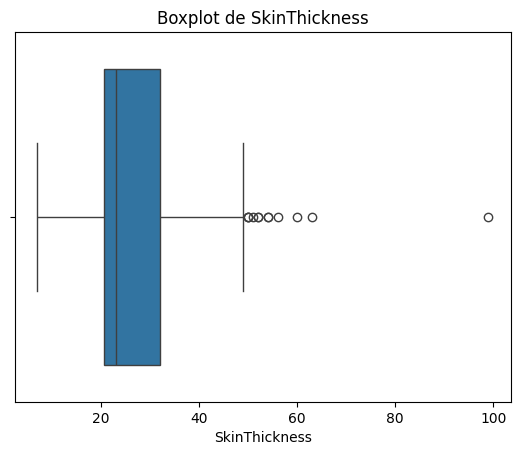

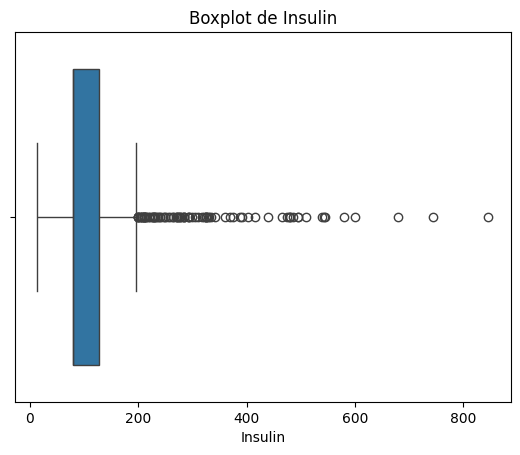

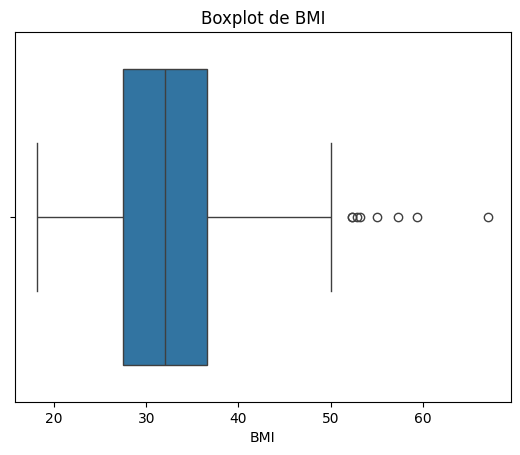

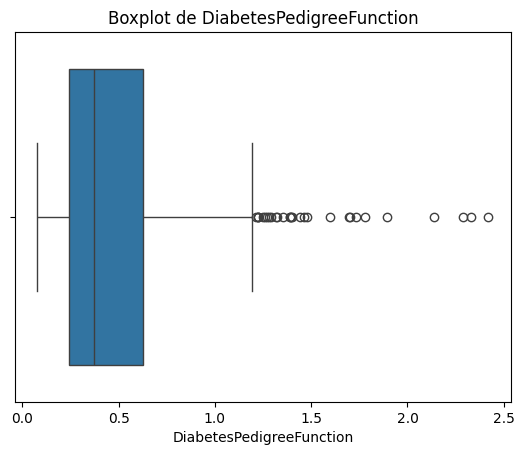

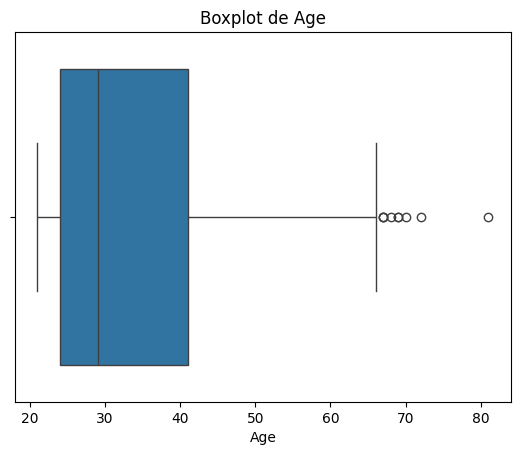

In [60]:
for col in ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
            'BMI', 'DiabetesPedigreeFunction', 'Age']:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()


Para poder eliminar los outliers de una manera fiable, voy a utilizar la forma propuesta del Z-score: Calcula cuántas desviaciones estándar está un valor respecto a la media. Si el Z-score es mayor que 3 o menor que -3, ese valor se considera un outlier.

In [61]:


columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for col in columns:
    z_scores = zscore(df[col])

    outliers = df[abs(z_scores) > 3]

    print(f'Número de outliers en {col} (Z-score > 3): {outliers.shape[0]}')

    #Eliminar los outliers del dataframe
    df = df[abs(z_scores) <= 3]


Número de outliers en Pregnancies (Z-score > 3): 4
Número de outliers en Glucose (Z-score > 3): 0
Número de outliers en BloodPressure (Z-score > 3): 8
Número de outliers en SkinThickness (Z-score > 3): 4
Número de outliers en Insulin (Z-score > 3): 20
Número de outliers en BMI (Z-score > 3): 3
Número de outliers en DiabetesPedigreeFunction (Z-score > 3): 10
Número de outliers en Age (Z-score > 3): 5


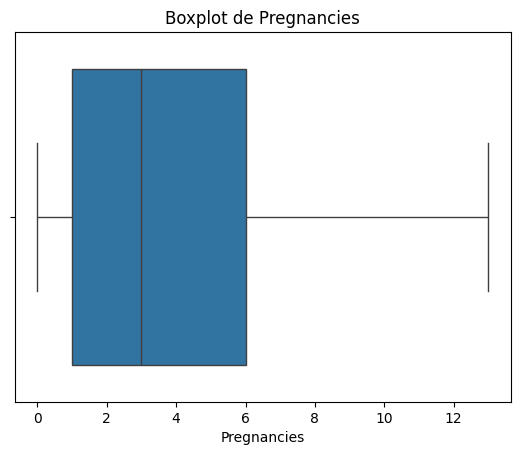

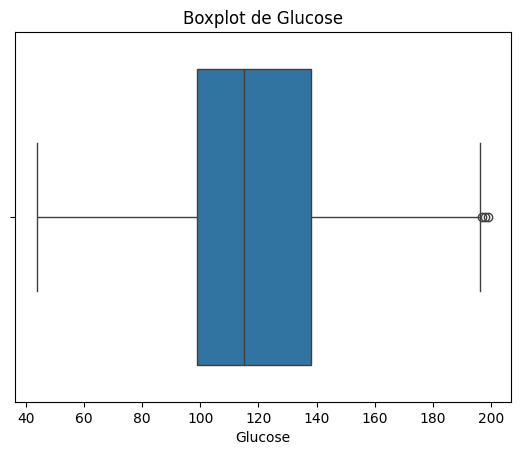

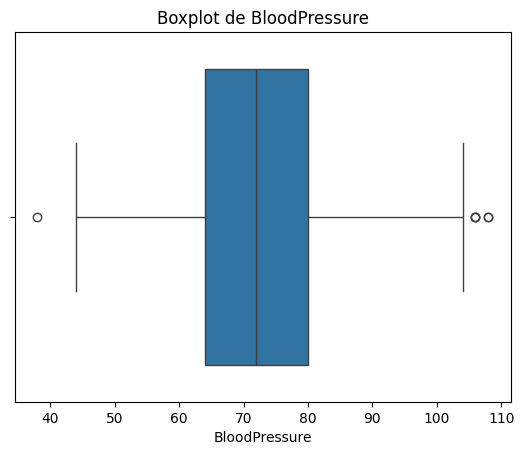

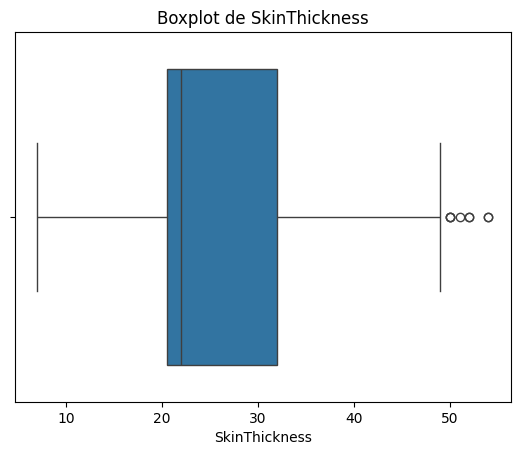

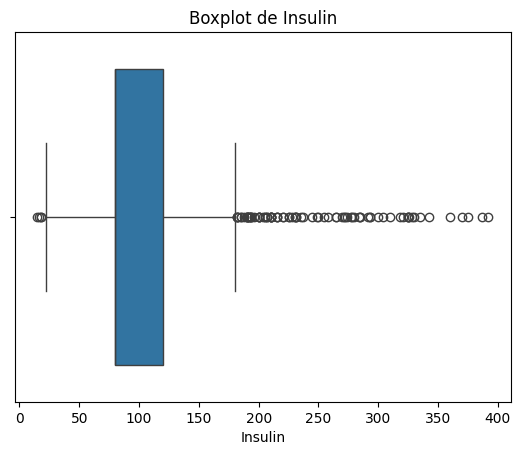

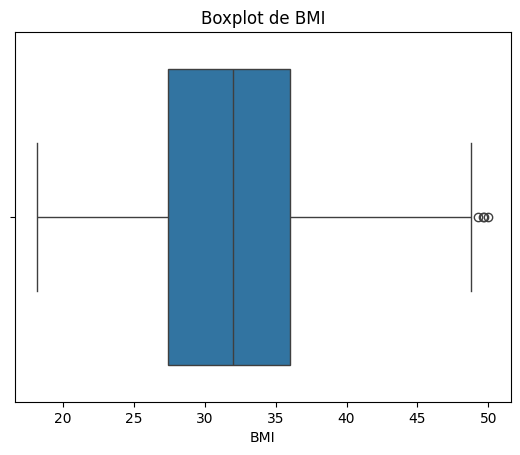

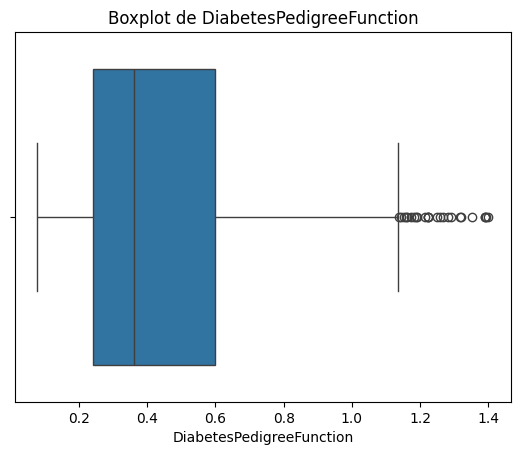

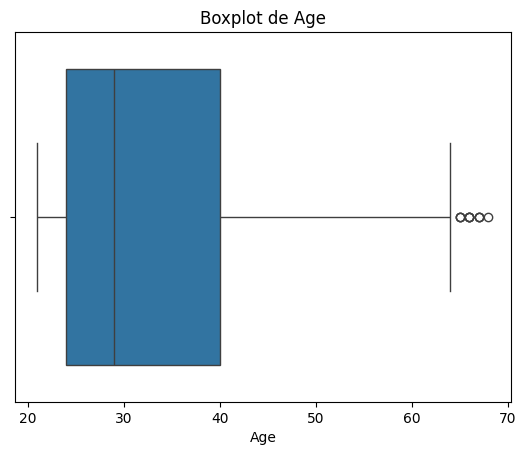

In [62]:
for col in ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
            'BMI', 'DiabetesPedigreeFunction', 'Age']:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

Como se puede comprobar, las cajas ahora muestran un resultado mas uniforme.

# Creación del árbol de decisión

In [63]:
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

selection_model = SelectKBest(k = 7)
selection_model.fit(X_train, y_train)

selected_columns = X_train.columns[selection_model.get_support()]
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = selected_columns)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = selected_columns)

X_train_sel.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,5.0,108.0,72.0,43.000000,36.1,0.263,33.0
1,5.0,99.0,74.0,27.000000,29.0,0.203,32.0
2,1.0,87.0,78.0,27.000000,34.6,0.101,22.0
3,3.0,106.0,72.0,20.536458,25.8,0.207,27.0
4,6.0,92.0,62.0,32.000000,32.0,0.085,46.0


In [65]:
train_data = X_train_sel  
test_data = X_test_sel  
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

In [66]:
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")
train_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,5.0,108.0,72.0,43.000000,36.1,0.263,33.0
1,5.0,99.0,74.0,27.000000,29.0,0.203,32.0
2,1.0,87.0,78.0,27.000000,34.6,0.101,22.0
3,3.0,106.0,72.0,20.536458,25.8,0.207,27.0
4,6.0,92.0,62.0,32.000000,32.0,0.085,46.0


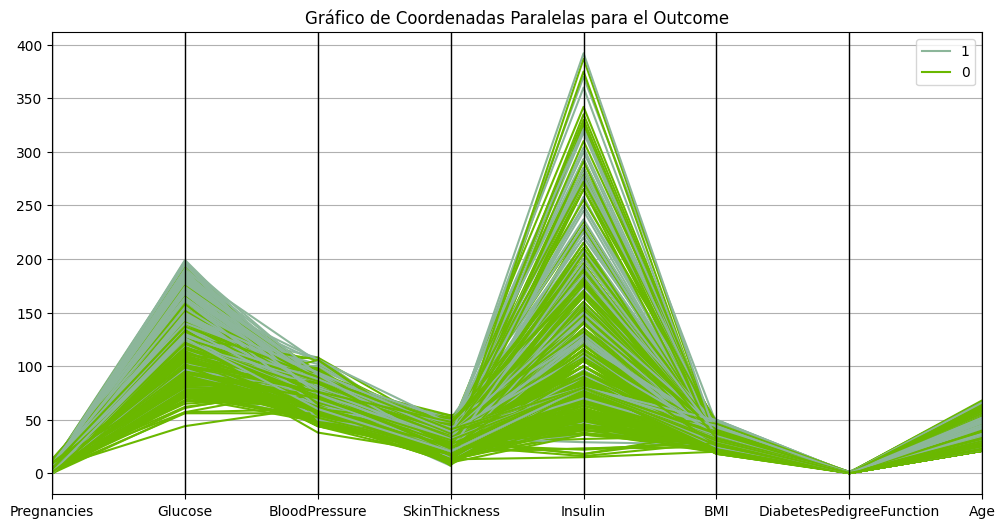

In [67]:
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df, "Outcome")
plt.title("Gráfico de Coordenadas Paralelas para el Outcome")
plt.show()


Preparamos los datos para el modelo (entrenamos)

In [68]:
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Creamos el árbol

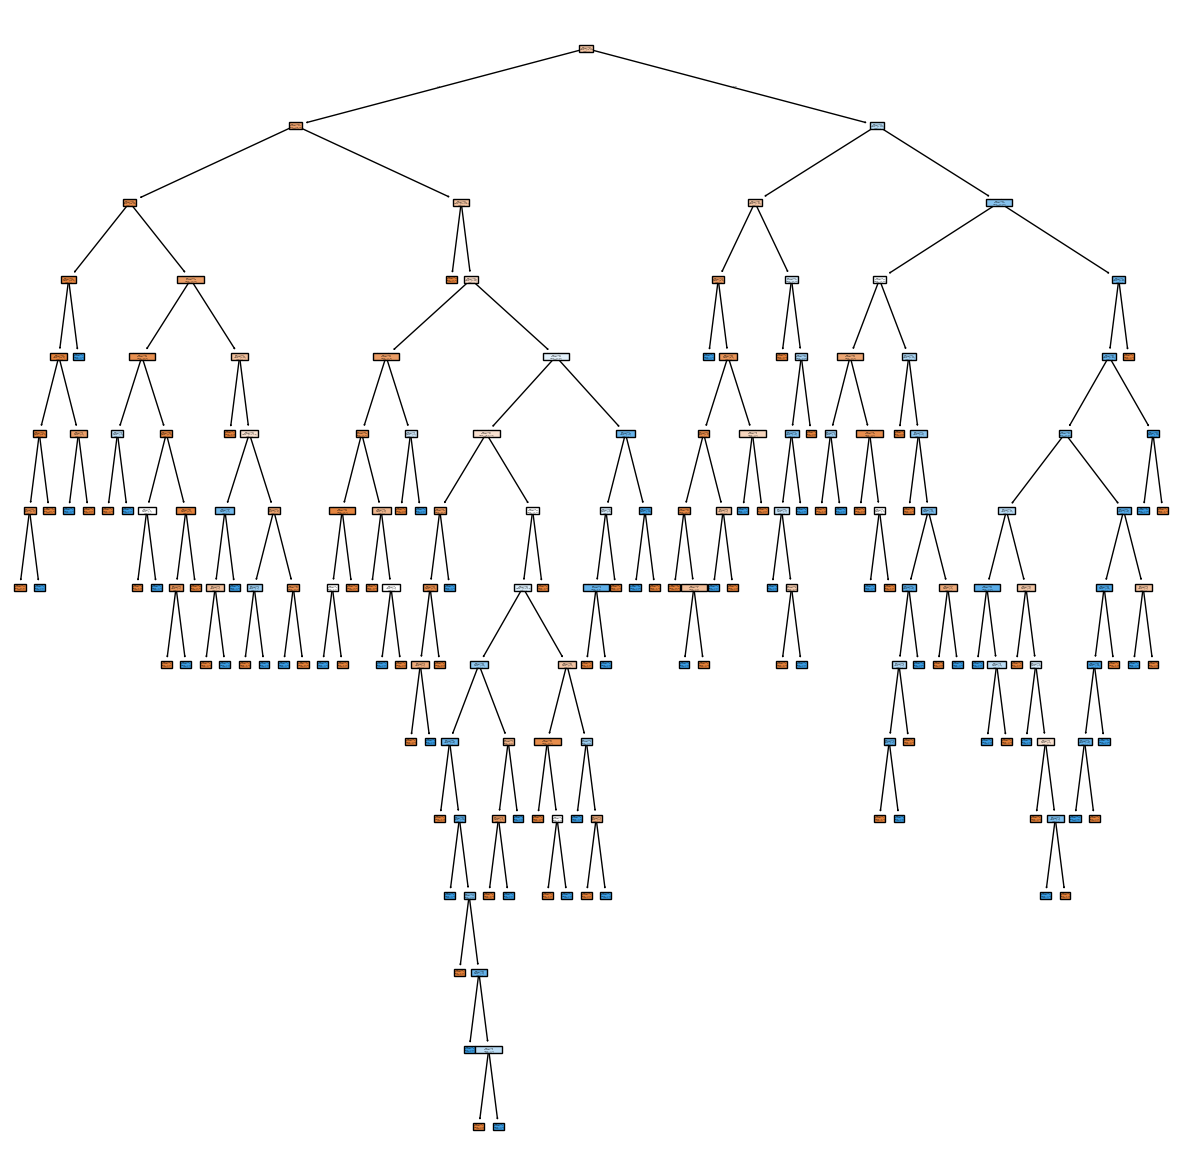

In [69]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)

plt.show()

Habiendo entrenado al modelo, realizamos predicciones

In [70]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

Y determinamos su precisión

In [71]:
accuracy_score(y_test, y_pred)

0.6853146853146853

Buscamos los mejores parámetros con GridSearch

In [72]:
hyperparams = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 10)
grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

Los printamos

In [73]:
grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


Y los ajustamos al modelo para comprobar si mejora su eficiencia

In [74]:
model = DecisionTreeClassifier(criterion = "gini", max_depth = 10, min_samples_leaf = 2, min_samples_split = 2, random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, random_state=42)

Sobre el nuevo entrenamiento, realizamos predicción

In [75]:
y_pred = model.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

Y vemos la precisión, que ha subido un 3.5%

In [76]:
accuracy_score(y_test, y_pred)

0.7202797202797203

# Random Forest

In [77]:

class RandomForestCustom:

    def __init__(self, n_estimators, random_state, max_depth, min_samples_leaf, max_features, X, y):
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.X = X
        self.y = y
        self.models = []

        if self.max_features > self.X.shape[1]:
            raise ValueError("max_features no puede ser mayor que el número de características del dataset.")

    def get_bootstrap_datasets(self):
        np.random.seed(self.random_state)
        idxs = [np.random.choice(range(len(self.X)), size=len(self.X), replace=True) for _ in range(self.n_estimators)]
        feature_idxs = [np.random.choice(range(self.X.shape[1]), size=self.max_features, replace=False) for _ in range(self.n_estimators)]
        return feature_idxs, [(self.X[idxs[i],:][:,feature_idxs[i]], self.y[idxs[i]]) for i in range(self.n_estimators)]

    def fit(self):
        feature_idxs, data_sets = self.get_bootstrap_datasets()
        for i, data in enumerate(data_sets):
            X_i, y_i = data
            tree_i = DecisionTreeClassifier(max_depth=self.max_depth, 
                                            min_samples_leaf=self.min_samples_leaf, 
                                            random_state=self.random_state)
            tree_i.fit(X_i, y_i)
            self.models.append((feature_idxs[i], tree_i))

    def predict(self, X):
        predictions = np.vstack([model.predict(X[:, idxs]) for idxs, model in self.models])
        predicciones = [Counter(predictions[:, i]).most_common(1)[0][0] for i in range(predictions.shape[1])]
        return np.array(predicciones)


In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [10,20,40 ,60],
    'max_depth': [5, 10, 20, None],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [1, 2, 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 5, 'n_estimators': 40}


Adapto la instancia RF con los mejores parámetros

In [79]:
rf_opti = RandomForestCustom(n_estimators=20, random_state=42, max_depth=20, min_samples_leaf=5, max_features=2, X=X_train.values, y=y_train.values)

In [80]:
rf_opti.fit()

### Evaluar el modelo optimizado en entrenamiento y prueba

In [81]:
train_pred_opti = rf_opti.predict(X_train.values)
test_pred_opti = rf_opti.predict(X_test.values)

In [82]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [83]:
get_metrics(y_train, y_test, train_pred_opti, test_pred_opti)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.865149,0.760125,0.806740,0.99187,0.616162,0.997319
Test,0.769231,0.421053,0.628006,0.80000,0.285714,0.970297
Diferencia,0.095918,0.339072,0.178735,0.19187,0.330447,0.027022


El hecho de que la accuracy sea mayor en train que en test, y con esa diferencia, indica un riesgo de overfitting. 

Dados los resultados de F1, viendo como caen los datos en test, se confirma que el modelo está sobreajustado. La diferencia en AUC es un indicador de lo mismo. 

Recall y specificity nos indican que el modelo generaliza mal para detectar verdaderos positivos en datos no vistos. Es decir, tiene una baja capacidad predictiva de positivos debido seguramente a una cantidad desbalanceada de positivos y negativos en los datos.

Specificity tambien indica que el modelo está mucho mejor ajustado a la hora de predecir negativos.


In [84]:
rf_opti2 = RandomForestCustom(n_estimators=20, random_state=42, max_depth=10, min_samples_leaf=10, max_features=2, X=X_train.values, y=y_train.values)

Reduzco la profundidad en 10 y aumento min_samples_leaf a 10

In [45]:
rf_opti2.fit()
train_pred_opti2 = rf_opti2.predict(X_train.values)
test_pred_opti2 = rf_opti2.predict(X_test.values)
get_metrics(y_train, y_test, train_pred_opti2, test_pred_opti2)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.809107,0.630508,0.729487,0.958763,0.469697,0.989276
Test,0.734266,0.269231,0.568482,0.700000,0.166667,0.970297
Diferencia,0.074841,0.361278,0.161005,0.258763,0.303030,0.018979


Accuracy sigue mostrando en la diferencia sobreajuste
F1 reafirma el sobreajuste con una caida en los datos de test.
AUC : Muestra que el modelo pierde capacidad predictiva en datos no vistos.


Visto el problema, dado que Boosting es una opcion para mejorarlo, vamos a ello: 

# Boosting de Algoritmo

In [85]:
class CustomBoosting:

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=10, 
                 min_samples_leaf=10, max_features=1.0, random_state=42):
        self.n_estimators = n_estimators  # Número de estimadores en el ensamble
        self.learning_rate = learning_rate  # Tasa de aprendizaje
        self.max_depth = max_depth  # Profundidad máxima de los árboles de decisión
        self.min_samples_leaf = min_samples_leaf  # Número mínimo de muestras por hoja
        self.max_features = max_features  # Proporción máxima de características a considerar en cada división
        self.random_state = random_state  # Semilla aleatoria para reproducibilidad
        self.estimadores = []  # Almacena los estimadores del ensamble

    def muestreo(self, X, y, pesos):
        """Realiza un muestreo ponderado de las instancias basado en los pesos."""
        indices = np.random.choice(a=len(X), size=len(X), p=pesos)
        return X.iloc[indices], y.iloc[indices]

    def get_error(self, y, y_pred, pesos):
        """Calcula el error ponderado de las predicciones."""
        instancias_erroneas = (y != y_pred)
        pesos_instancias_erroneas = pesos[instancias_erroneas]
        suma_pesos_error = np.sum(pesos_instancias_erroneas)
        error_ponderado = suma_pesos_error / np.sum(pesos)
        return instancias_erroneas, error_ponderado

    def get_estimator_importance(self, error_ponderado):
        """Calcula la importancia de un estimador."""
        if error_ponderado == 0:  # Caso perfecto
            return np.inf
        return np.log((1 - error_ponderado) / error_ponderado) * self.learning_rate

    def update_pesos(self, estimator_importance, instancias_erroneas, pesos):
        """Actualiza los pesos de las instancias para dar más importancia a las mal clasificadas."""
        actualizacion_pesos = np.where(instancias_erroneas, np.exp(estimator_importance), np.exp(-estimator_importance))
        pesos = pesos * actualizacion_pesos
        pesos = pesos / np.sum(pesos)  # Normaliza los pesos
        return pesos

    def fit(self, X, y):
        """Entrena el modelo con boosting personalizado."""
        # Validar los datos
        if X.isnull().any().any() or y.isnull().any():
            raise ValueError("Los datos contienen valores nulos. Por favor, límpialos antes de entrenar el modelo.")
        if len(X) != len(y):
            raise ValueError("X e y deben tener el mismo número de filas.")
        
        # Inicializar los pesos de las instancias
        pesos = np.ones(len(X)) / len(X)
        
        # Entrenar los estimadores
        for _ in range(self.n_estimators):
            # Realizar un muestreo ponderado
            X_sampled, y_sampled = self.muestreo(X, y, pesos)
            
            # Entrenar el estimador base
            estimador = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                random_state=self.random_state
            ).fit(X_sampled, y_sampled)
            
            # Realizar predicciones con el estimador
            y_pred = estimador.predict(X)
            
            # Calcular el error y la importancia del estimador
            instancias_erroneas, error_ponderado = self.get_error(y, y_pred, pesos)
            estimator_importance = self.get_estimator_importance(error_ponderado)
            
            # Almacenar el estimador y su importancia
            self.estimadores.append((estimador, estimator_importance))
            
            # Actualizar los pesos
            pesos = self.update_pesos(estimator_importance, instancias_erroneas, pesos)

    def predict(self, X):
        """Realiza predicciones basadas en los estimadores entrenados."""
        # Predicción final acumulativa
        final_predictions = np.zeros(len(X))
        
        for estimador, estimator_importance in self.estimadores:
            # Predicciones ponderadas
            predicciones = estimador.predict(X)
            preds_ponderada = predicciones * estimator_importance
            final_predictions += preds_ponderada
        
        # Tomar la decisión final (mayoría ponderada)
        mean_val = np.mean(final_predictions)
        yhats = np.where(final_predictions < mean_val, 0, 1)
        return yhats


In [86]:
# Entrenamos el modelo de Boosting
clf = CustomBoosting(n_estimators=10, learning_rate=0.01, max_depth=7, min_samples_leaf=7, max_features=X_train.shape[1]//2)
clf.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de entrenamiento y prueba
test_pred = clf.predict(X_test)
train_pred = clf.predict(X_train)

# Evaluamos el rendimiento del modelo
get_metrics(y_train, y_test, train_pred, test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.840630,0.796421,0.854321,0.714859,0.898990,0.809651
Test,0.762238,0.666667,0.776049,0.566667,0.809524,0.742574
Diferencia,0.078393,0.129754,0.078272,0.148193,0.089466,0.067077


Precision: La diferencia es razonable y esperada, ya que boosting puede comprometer ligeramente la precisión
F1: La diferencia aún se podría optimizar, pero entra dentro de lo razonable.
Se han reducido considerablemente las diferencias, lo que muestra una mayor capacidad de prediccion tanto de negativos como positivos